# Multi-fidelity Multi-objective Bayesian Optimization

Here we attempt to solve for the constrained Pareto front of the TNK multi-objective
optimization problem using Multi-Fidelity Multi-Objective Bayesian optimization. For
simplicity we assume that the objective and constraint functions at lower fidelities is
exactly equal to the functions at higher fidelities (this is obviously not a
requirement, although for the best results lower fidelity calculations should
correlate with higher fidelity ones). The algorithm should learn this relationship
and use information gathered at lower fidelities to gather samples to improve the
hypervolume of the Pareto front at the maximum fidelity.

TNK function
$n=2$ variables:
$x_i \in [0, \pi], i=1,2$

Objectives:
- $f_i(x) = x_i$

Constraints:
- $g_1(x) = -x_1^2 -x_2^2 + 1 + 0.1 \cos\left(16 \arctan \frac{x_1}{x_2}\right) \le 0$
- $g_2(x) = (x_1 - 1/2)^2 + (x_2-1/2)^2 \le 0.5$

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
N_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20
BUDGET = 0.02 if SMOKE_TEST else 10

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch

from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MultiFidelityGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

evaluator = Evaluator(function=evaluate_TNK)
print(tnk_vocs.dict())

{'variables': {'x1': [0.0, 3.14159], 'x2': [0.0, 3.14159]}, 'constraints': {'c1': ['GREATER_THAN', 0.0], 'c2': ['LESS_THAN', 0.5]}, 'objectives': {'y1': 'MINIMIZE', 'y2': 'MINIMIZE'}, 'constants': {'a': 'dummy_constant'}, 'observables': []}


## Set up the Multi-Fidelity Multi-objective optimization algorithm
Here we create the Multi-Fidelity generator object which can solve both single and
multi-objective optimization problems depending on the number of objectives in VOCS.
We specify a cost function as a function of fidelity parameter $s=[0,1]$ as $C(s) =
s^{3.5}$ as an example from a real life multi-fidelity simulation problem.

In [2]:
from copy import deepcopy
my_vocs = deepcopy(tnk_vocs)
my_vocs.constraints = {}
generator = MultiFidelityGenerator(vocs=my_vocs, reference_point = {"y1":1.5,"y2":1.5})

# set cost function according to approximate scaling of laser plasma accelerator
# problem, see https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.5.013063
generator.cost_function = lambda s: s**3.5
generator.numerical_optimizer.n_restarts = NUM_RESTARTS
generator.n_monte_carlo_samples = N_MC_SAMPLES

X = Xopt(generator=generator, evaluator=evaluator, vocs=my_vocs)

# evaluate at some explicit initial points
X.evaluate_data(pd.DataFrame({"x1":[1.0, 0.75],"x2":[0.75, 1.0],"s":[0.0,0.1]}))

X


            Xopt
________________________________
Version: 0+untagged.1.g2e9a465
Data size: 2
Config as YAML:
dump_file: null
evaluator:
  function: xopt.resources.test_functions.tnk.evaluate_TNK
  function_kwargs:
    raise_probability: 0
    random_sleep: 0
    sleep: 0
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  custom_objective: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    custom_noise_prior: null
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances: null
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: multi_fidelity
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  reference_point:
    s: 0.0
    y1: 1.5
    y2: 1.5
  supports_batch_generation: true
  supports_multi_objective: true
  turbo_

## Run optimization routine
Instead of ending the optimization routine after an explict number of samples we end
optimization once a given optimization budget has been exceeded. WARNING: This will
slightly exceed the given budget

In [3]:
budget = BUDGET
while X.generator.calculate_total_cost() < budget:
    X.step()
    print(f"n_samples: {len(X.data)} "
          f"budget used: {X.generator.calculate_total_cost():.4} "
          f"hypervolume: {X.generator.calculate_hypervolume():.4}")

n_samples: 3 budget used: 0.009122 hypervolume: 0.0375


n_samples: 4 budget used: 0.0152 hypervolume: 0.0375


n_samples: 5 budget used: 0.0252 hypervolume: 0.4036


n_samples: 6 budget used: 0.02522 hypervolume: 0.4161


n_samples: 7 budget used: 0.02579 hypervolume: 0.4161


n_samples: 8 budget used: 0.02579 hypervolume: 0.4161


n_samples: 9 budget used: 0.02781 hypervolume: 0.5302


n_samples: 10 budget used: 0.07892 hypervolume: 0.962


n_samples: 11 budget used: 0.3203 hypervolume: 1.499


n_samples: 12 budget used: 1.053 hypervolume: 2.059


n_samples: 13 budget used: 1.174 hypervolume: 2.059


n_samples: 14 budget used: 1.243 hypervolume: 2.059


n_samples: 15 budget used: 1.254 hypervolume: 2.059


n_samples: 16 budget used: 1.254 hypervolume: 2.059


n_samples: 17 budget used: 1.923 hypervolume: 2.059


n_samples: 18 budget used: 1.937 hypervolume: 2.059


n_samples: 19 budget used: 2.937 hypervolume: 2.25


n_samples: 20 budget used: 3.189 hypervolume: 2.25


n_samples: 21 budget used: 4.189 hypervolume: 2.25


n_samples: 22 budget used: 4.815 hypervolume: 2.25


n_samples: 23 budget used: 4.855 hypervolume: 2.25


n_samples: 24 budget used: 5.855 hypervolume: 2.25


n_samples: 25 budget used: 5.855 hypervolume: 2.25


n_samples: 26 budget used: 5.875 hypervolume: 2.25


n_samples: 27 budget used: 6.749 hypervolume: 2.25


n_samples: 28 budget used: 6.978 hypervolume: 2.25


n_samples: 29 budget used: 6.983 hypervolume: 2.25


n_samples: 30 budget used: 7.217 hypervolume: 2.25


n_samples: 31 budget used: 7.218 hypervolume: 2.25


n_samples: 32 budget used: 8.218 hypervolume: 2.25


n_samples: 33 budget used: 9.186 hypervolume: 2.25


n_samples: 34 budget used: 9.188 hypervolume: 2.25


n_samples: 35 budget used: 9.499 hypervolume: 2.25


n_samples: 36 budget used: 9.653 hypervolume: 2.25


n_samples: 37 budget used: 9.697 hypervolume: 2.25


n_samples: 38 budget used: 9.699 hypervolume: 2.25


n_samples: 39 budget used: 9.704 hypervolume: 2.25


n_samples: 40 budget used: 9.709 hypervolume: 2.25


n_samples: 41 budget used: 10.12 hypervolume: 2.25


## Show results

In [4]:
X.data

,x1,x2,s,a,y1,y2,c1,c2,xopt_runtime,xopt_error
0,1.000000,0.750000,0.000000,dummy_constant,1.000000,0.750000,0.626888,0.312500,0.000041,False
1,0.750000,1.000000,0.100000,dummy_constant,0.750000,1.000000,0.626888,0.312500,0.000018,False
2,0.000000,2.271957,0.258699,dummy_constant,0.000000,2.271957,4.061786,3.389830,0.000023,False
3,1.923706,3.128161,0.232666,dummy_constant,1.923706,3.128161,12.568388,8.934168,0.000022,False
4,0.000000,0.497109,0.268270,dummy_constant,0.000000,0.497109,-0.852883,0.250008,0.000021,False
5,0.000000,0.312835,0.045472,dummy_constant,0.000000,0.312835,-1.002134,0.285031,0.000023,False
6,0.000000,0.818865,0.118385,dummy_constant,0.000000,0.818865,-0.429460,0.351675,0.000022,False
7,0.000000,0.000000,0.000000,dummy_constant,0.000000,0.000000,-1.100000,0.500000,0.000023,False
8,0.000000,0.000000,0.169856,dummy_constant,0.000000,0.000000,-1.100000,0.500000,0.000024,False
9,0.000000,0.000000,0.427566,dummy_constant,0.000000,0.000000,-1.100000,0.500000,0.000023,False


## Plot results
Here we plot the resulting observations in input space, colored by feasibility
(neglecting the fact that
these data points are at varying fidelities).


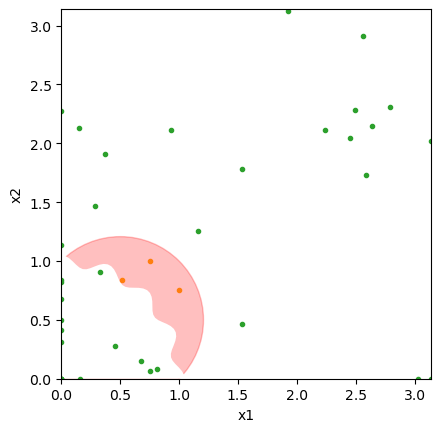

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

theta = np.linspace(0, np.pi / 2)
r = np.sqrt(1 + 0.1 * np.cos(16 * theta))
x_1 = r * np.sin(theta)
x_2_lower = r * np.cos(theta)
x_2_upper = (0.5 - (x_1 - 0.5) ** 2) ** 0.5 + 0.5

z = np.zeros_like(x_1)

# ax2.plot(x_1, x_2_lower,'r')
ax.fill_between(x_1, z, x_2_lower, fc="white")
circle = plt.Circle(
    (0.5, 0.5), 0.5 ** 0.5, color="r", alpha=0.25, zorder=0, label="Valid Region"
)
ax.add_patch(circle)
history = pd.concat(
    [X.data, tnk_vocs.feasibility_data(X.data)], axis=1, ignore_index=False
)

ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

ax.set_xlim(0, 3.14)
ax.set_ylim(0, 3.14)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect("equal")

### Plot path through input space

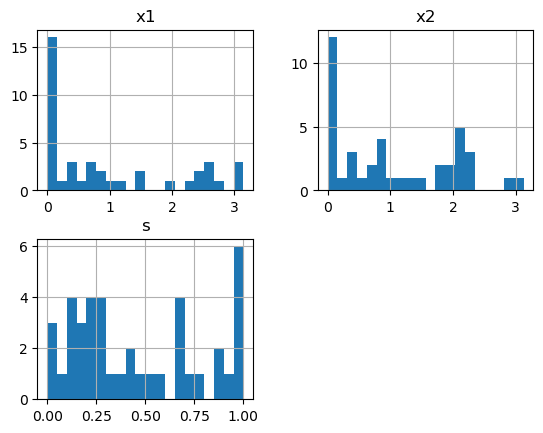

In [6]:
ax = history.hist(["x1", "x2", "s"],bins=20)

<Axes: >

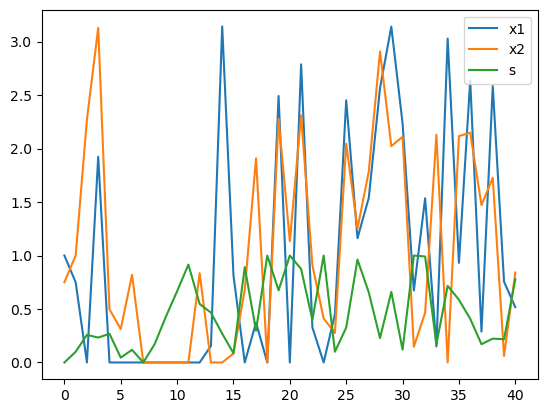

In [7]:
history.plot(y=["x1", "x2", "s"])

## Plot the acqusisition function
Here we plot the acquisition function at a small set of fidelities $[0, 0.5, 1.0]$.

[[0.46210772 1.16136891]]


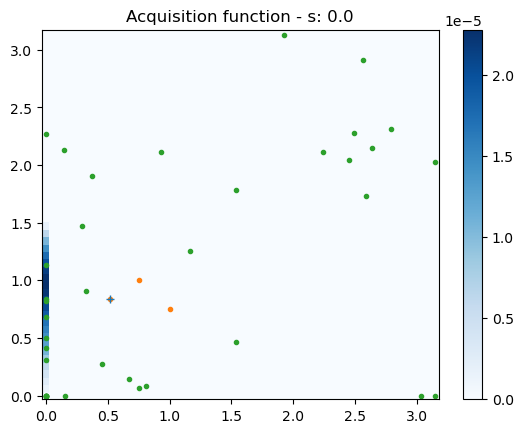

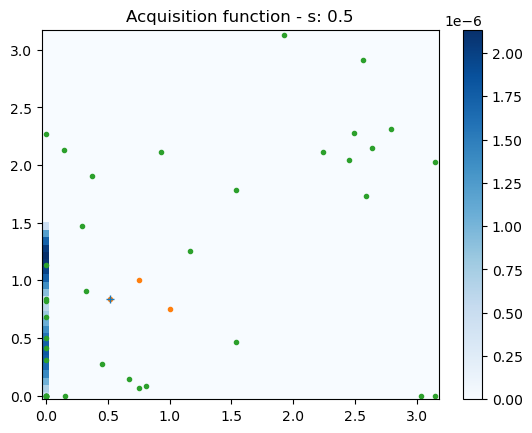

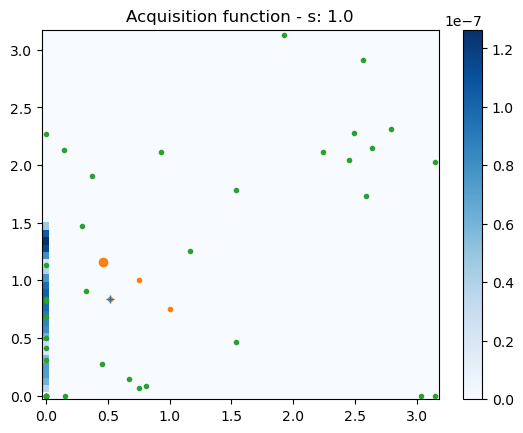

In [8]:
# plot the acquisition function

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh over non-fidelity parameters
n = 50
x = torch.linspace(*bounds.T[1], n)
y = torch.linspace(*bounds.T[2], n)
xx, yy = torch.meshgrid(x, y)

# plot function(s) at a single fidelity parameter
fidelities = [0.0, 0.5, 1.0]
for fidelity in fidelities:
    pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()
    pts = torch.cat((torch.ones(pts.shape[0],1)*fidelity, pts), dim=-1)

    acq_func = X.generator.get_acquisition(model)
    with torch.no_grad():
        acq_pts = pts.unsqueeze(1)
        acq = acq_func(acq_pts)

        fig, ax = plt.subplots()

        xxn, yyn = xx.numpy(), yy.numpy()

        c = ax.pcolor(xxn, yyn, acq.reshape(n, n), cmap="Blues")
        fig.colorbar(c)
        ax.set_title(f"Acquisition function - s: {fidelity}")

        ax.plot(*history[["x1", "x2"]][history["feasible"]].to_numpy().T, ".C1")
        ax.plot(*history[["x1", "x2"]][~history["feasible"]].to_numpy().T, ".C2")

        ax.plot(*history[["x1", "x2"]].to_numpy()[-1].T, "+")


candidate = pd.DataFrame(X.generator.generate(1), index=[0])
print(candidate[["x1", "x2"]].to_numpy())
ax.plot(*candidate[["x1", "x2"]].to_numpy()[0], "o")

In [9]:
# examine lengthscale of the first objective
list(model.models[0].named_parameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([-26.8265], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(0.1247, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(-0.0596, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0.7803, 2.6383, 2.6271]], dtype=torch.float64, requires_grad=True))]